In [1]:
import cv2
import numpy as np 
import os
import matplotlib.pyplot as plt 
import pandas as pd 
import tensorflow as tf
import tensorflow.keras as keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dropout, Dense, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras import callbacks

In [2]:
unhealthy = ['Data/Parasitized/' + i for i in os.listdir('Data/Parasitized/')]
healthy = ['Data/Uninfected/' + i for i in os.listdir('Data/Uninfected/')]

In [3]:
train_features = unhealthy[:12402]
train_features.extend(healthy[:12402])
train_labels = ['unhealthy']*12402
train_labels.extend(['healthy']*12402)

valid_features = unhealthy[12402:13091]
valid_features.extend(healthy[12402:13091])
valid_labels = ['unhealthy']*689
valid_labels.extend(['healthy']*689)

test_features = unhealthy[13091:]
test_features.extend(healthy[13091:])
test_labels = ['unhealthy']*689
test_labels.extend(['healthy']*689)

In [4]:
train_df = pd.DataFrame({'path':train_features, 'label':train_labels})
valid_df = pd.DataFrame({'path':valid_features, 'label':test_labels})
test_df = pd.DataFrame({'path':test_features, 'label':valid_labels})

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(train_df,
                                       x_col='path',
                                       y_col='label',
                                       batch_size=32,
                                       shuffle=True,
                                       seed=1,
                                       class_mode='categorical',
                                       target_size=(128,128))

valid_gen = datagen.flow_from_dataframe(valid_df,
                                       x_col='path',
                                       y_col='label',
                                       batch_size=32,
                                       shuffle=True,
                                       seed=2,
                                       class_mode='categorical',
                                       target_size=(128,128))

test_gen = datagen.flow_from_dataframe(test_df,
                                       x_col='path',
                                       y_col='label',
                                       batch_size=32,
                                       shuffle=True,
                                       seed=3,
                                       class_mode='categorical',
                                       target_size=(128,128))

Found 24804 validated image filenames belonging to 2 classes.
Found 1378 validated image filenames belonging to 2 classes.
Found 1376 validated image filenames belonging to 2 classes.


D:\Anaconda\envs\tf2\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [24]:
chkpnt = callbacks.ModelCheckpoint('checkpoint', save_weights_only=False, save_best_only=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=4)

In [20]:
model = keras.Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(128,128,3)))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D((2,2)))

model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 124, 124, 32)      18464     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 122, 122, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 59, 59, 64)        18496     
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 57, 57, 32)        18464     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 55, 55, 32)       

In [25]:
h = model.fit(train_gen, epochs=15, verbose=1, callbacks=[chkpnt, reduce_lr], validation_data=valid_gen)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 776 steps, validate for 44 steps
Epoch 1/15
775/776 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9712
Epoch 00001: val_loss improved from inf to 0.14571, saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint\assets
776/776 [==============================] - 213s 274ms/step - loss: 0.0843 - accuracy: 0.9712 - val_loss: 0.1457 - val_accuracy: 0.9470
Epoch 2/15
775/776 [============================>.] - ETA: 0s - loss: 0.0642 - accuracy: 0.9788
Epoch 00002: val_loss did not improve from 0.14571
776/776 [==============================] - 235s 302ms/step - loss: 0.0642 - accuracy: 0.9788 - val_loss: 0.2042 - val_accuracy: 0.9434
Epoch 3/15
775/776 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9878
Epoch 00003: val_loss did not improve from 0.14571
776/776 [==============================] - 222s 286ms/step - loss: 0.0378 - accuracy: 0.9878 - val_loss: 0.2020 - v

In [27]:
model.save('final_model.hdf5')

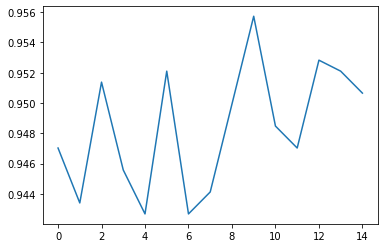

In [32]:
plt.plot(h.history['val_accuracy'])

In [38]:
model.evaluate(test_gen)

  ...
    to  
  ['...']
43/43 [==============================] - 2s 39ms/step - loss: 0.7180 - accuracy: 0.9273


[0.7179992913412249, 0.9273256]

In [61]:
from tensorflow.keras.models import load_model
m2 = load_model('checkpoint')

In [65]:
m2.evaluate(test_gen)

  ...
    to  
  ['...']
43/43 [==============================] - 2s 46ms/step - loss: 0.2338 - accuracy: 0.9201


[0.23376682201443716, 0.92005813]